In [316]:
import numpy as np
from scipy.stats import norm

from sklearn import decomposition

import matplotlib.pyplot as plt
from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
%matplotlib inline

In [204]:
depth_bin_num = 1046
pings_per_day = 240
num_days = 30

In [104]:
fs = 1./240
t_in_day = np.arange(pings_per_day)

In [105]:
fs

0.004166666666666667

In [151]:
dvm_freq = 1./(2*pings_per_day)*2  # frequency of dvm pattern
simu_sine = (0.4*np.sin(2*np.pi*dvm_freq*t_in_day-5*np.pi/10)+0.5)*depth_bin_num  # mean location of dvm pattern

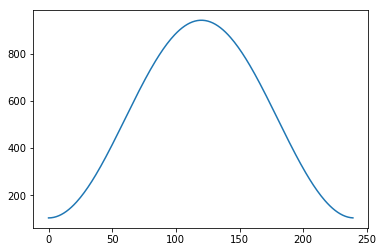

In [152]:
plt.plot(simu_sine)

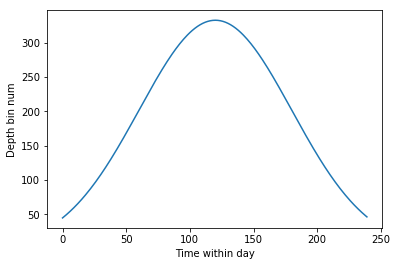

In [156]:
x_in_day = np.arange(pings_per_day)  # each ping within a day
norm_w = norm(scale=60,loc=120).pdf(x_in_day)*50000  # width of dvm pattern
fig,ax = plt.subplots(1)
ax.plot(norm_w)
ax.set_xlabel('Time within day')
ax.set_ylabel('Depth bin num')

In [160]:
x_depth = np.arange(depth_bin_num)  # each depth bin within each ping
mtx = np.empty((depth_bin_num,pings_per_day))
for p in t_in_day:
    mtx_tmp = norm(scale=norm_w[p],loc=simu_sine[p]).pdf(x_depth)
    mtx[:,p] = mtx_tmp/mtx_tmp.max()

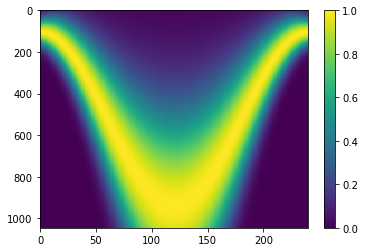

In [202]:
plt.imshow(mtx,aspect='auto')
plt.colorbar()

In [283]:
b_depth_mean_center = 200  # mean of subsurface layer
b_depth_mean = b_depth_mean_center+(np.random.rand(pings_per_day)-0.5)*5
b_norm_w = norm(scale=40,loc=120).pdf(x_in_day)*10000  # width of dvm pattern
b_mtx = np.empty((depth_bin_num,pings_per_day))
for p in t_in_day:
    b_mtx_tmp = norm(scale=b_norm_w[p],loc=b_depth_mean[p]).pdf(x_depth)
    b_mtx[:,p] = b_mtx_tmp/b_mtx_tmp.max()

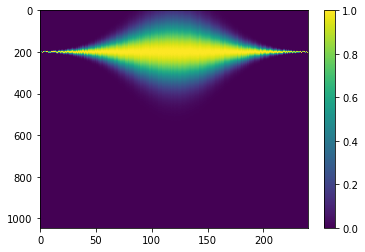

In [284]:
plt.imshow(b_mtx,aspect='auto')
plt.colorbar()

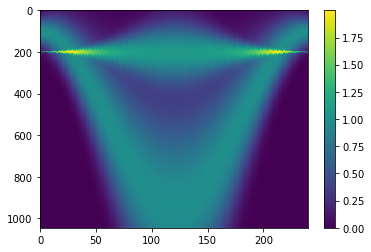

In [285]:
plt.imshow(mtx+1*b_mtx,aspect='auto')
plt.colorbar()

In [304]:
big_mtx = np.empty((num_days,depth_bin_num,pings_per_day))  # big mtx with [depth x ping] frames of days
x_day = np.arange(num_days)
fade_dvm = np.sin(2*np.pi*1./20*x_day)*0.5+1  #1*np.ones(num_days)
fade_b = norm(scale=15).pdf(x_day)
fade_b = fade_b/fade_b.max()*2
for day in x_day:
    big_mtx[day,:,:] = mtx*fade_dvm[day] + b_mtx*fade_b[day]

In [305]:
big_mtx_rshp = np.reshape(big_mtx.swapaxes(1,2),(-1,depth_bin_num))
big_mtx_rshp.shape

(7200, 1046)

In [306]:
big_mtx.shape

(30, 1046, 240)

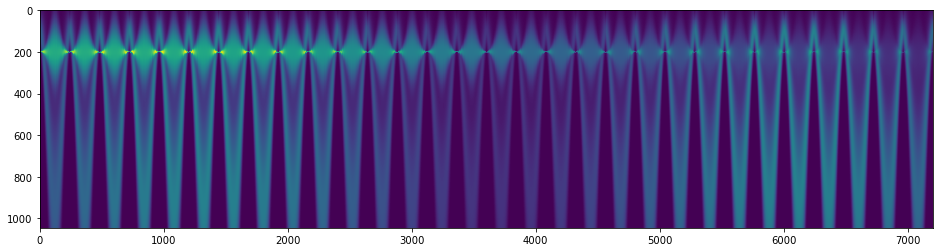

In [307]:
fig,ax=plt.subplots(1)
ax.imshow(big_mtx_rshp.swapaxes(0,1),aspect='auto')
fig.set_figwidth(16)

In [308]:
big_mtx_vec = np.reshape(big_mtx.swapaxes(1,2),(num_days,depth_bin_num*pings_per_day))
big_mtx_vec.shape

(30, 251040)

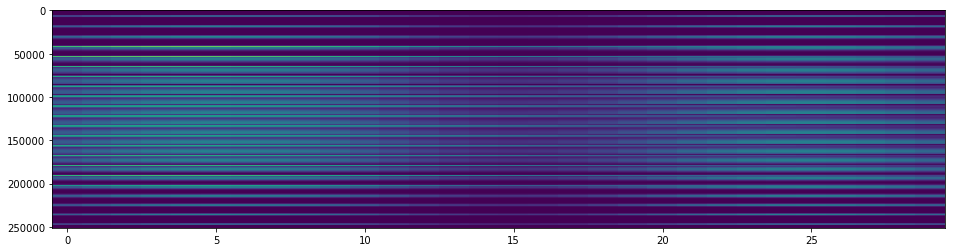

In [311]:
fig,ax=plt.subplots(1)
ax.imshow(big_mtx_vec.T,aspect='auto')
fig.set_figwidth(16)

In [313]:
np.argwhere(big_mtx<0)

array([], shape=(0, 3), dtype=int64)

In [329]:
n_comp=4
nmf = decomposition.NMF(n_components=n_comp)
nmf.fit(big_mtx_vec)
r_nmf = nmf.transform(big_mtx_vec)  # tranformation                                             
nmf_comps = np.reshape(nmf.components_,(-1,pings_per_day,depth_bin_num))  # get nmf components                               

In [330]:
nmf_comps.shape

(4, 240, 1046)

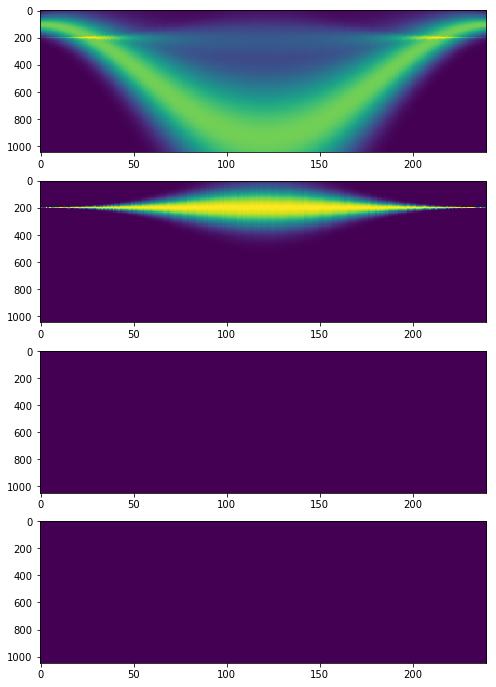

In [331]:
fig,ax=plt.subplots(n_comp,1)
for c in np.arange(n_comp):
    imshow(ax[c],nmf_comps[c,:,:].swapaxes(0,1),aspect='auto')
fig.set_figwidth(8)
fig.set_figheight(12)